In [43]:
from datasets import load_dataset

In [44]:
dataset = load_dataset("papluca/language-identification")

In [45]:
train_dataset = dataset["train"]
test_dataset = dataset["test"]
validation_dataset = dataset["validation"]

In [46]:
from datasets import concatenate_datasets

full_dataset = concatenate_datasets([
    train_dataset,
    test_dataset,
    validation_dataset
])

In [47]:
languages = ['en', 'de', 'fr', 'it', 'es']

In [48]:
full_dataset = full_dataset.filter(lambda x: x['labels'] in languages)

Filter: 100%|██████████| 90000/90000 [00:00<00:00, 263681.04 examples/s]


In [49]:
len(full_dataset)

22500

## Langdetect Library Method

In [50]:
from collections import defaultdict
from langdetect import detect, DetectorFactory, LangDetectException
DetectorFactory.seed = 0

def evaluate_langdetect(dataset):
    total = 0
    correct = 0
    wrong = 0
    errors = 0
    language_counts = defaultdict(lambda: {"correct": 0, "total": 0})

    for sample in dataset:
        text = sample["text"]
        true_label = sample["labels"]

        try:
            predicted_label = detect(text)
            if predicted_label == true_label:
                correct += 1
                language_counts[true_label]["correct"] += 1
            else:
                wrong += 1
            language_counts[true_label]["total"] += 1
            total += 1
        except LangDetectException:
            errors += 1

    accuracy = correct / total if total > 0 else 0

    return {
        "overall_accuracy": accuracy,
        "total": total,
        "correct": correct,
        "wrong": wrong,
        "errors": errors,
        "per_language": {
            lang: {
                "accuracy": stats["correct"] / stats["total"],
                "correct": stats["correct"],
                "total": stats["total"]
            }
            for lang, stats in language_counts.items()
        }
    }


## Custom Cavnar & Trenkle Method

In [51]:
import os
import sys
sys.path.append(os.path.abspath(os.path.join('..')))
from language_detector import LanguageIdentifier
language_identifier = LanguageIdentifier(n=3, top_k=400, penalty=400)

In [52]:
for lang in ['en', 'de', 'fr', 'it', 'es']:
    file_path = os.path.join('..', 'languages', f'{lang}.txt')
    with open(file_path, 'r', encoding='utf-8') as f:
        text = f.read()
        language_identifier.add_language(lang, text)

In [53]:
from collections import defaultdict

def evaluate_custom_langdetect(dataset):
    total = 0
    correct = 0
    wrong = 0
    errors = 0
    language_counts = defaultdict(lambda: {"correct": 0, "total": 0})

    for sample in dataset:
        text = sample["text"]
        true_label = sample["labels"]

        try:
            predicted_label, _ = language_identifier.identify_language(text)
            if predicted_label == true_label:
                correct += 1
                language_counts[true_label]["correct"] += 1
            else:
                wrong += 1
            language_counts[true_label]["total"] += 1
            total += 1
        except Exception:
            errors += 1

    accuracy = correct / total if total > 0 else 0

    print(f"\n--- Overall Performance ---")
    print(f"Total samples evaluated: {total}")
    print(f"Correct predictions: {correct}")
    print(f"Wrong predictions: {wrong}")
    print(f"Detection errors: {errors}")
    print(f"Overall Accuracy: {accuracy:.4f}\n")

    print("--- Per-Language Accuracy ---")
    for lang, stats in language_counts.items():
        lang_acc = stats["correct"] / stats["total"] if stats["total"] > 0 else 0
        print(f"{lang}: {lang_acc:.4f} ({stats['correct']}/{stats['total']})")

    return {
        "overall_accuracy": accuracy,
        "total": total,
        "correct": correct,
        "wrong": wrong,
        "errors": errors,
        "per_language": {
            lang: {
                "accuracy": stats["correct"] / stats["total"],
                "correct": stats["correct"],
                "total": stats["total"]
            }
            for lang, stats in language_counts.items()
        }
    }


In [54]:
results_custom = evaluate_custom_langdetect(full_dataset)
results_langdetect = evaluate_langdetect(full_dataset)


--- Overall Performance ---
Total samples evaluated: 22500
Correct predictions: 21913
Wrong predictions: 587
Detection errors: 0
Overall Accuracy: 0.9739

--- Per-Language Accuracy ---
es: 0.9856 (4435/4500)
it: 0.9309 (4189/4500)
de: 0.9900 (4455/4500)
fr: 0.9880 (4446/4500)
en: 0.9751 (4388/4500)


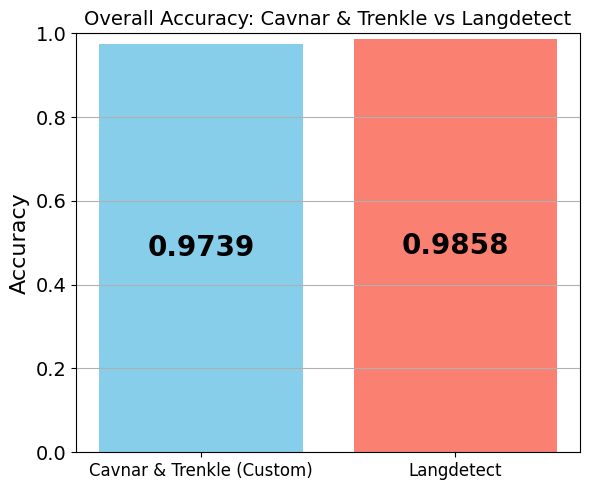

In [81]:
import matplotlib.pyplot as plt

custom_acc = results_custom["overall_accuracy"]
langdetect_acc = results_langdetect["overall_accuracy"]

models = ["Cavnar & Trenkle (Custom)", "Langdetect"]
accuracies = [custom_acc, langdetect_acc]

plt.figure(figsize=(6, 5))
bars = plt.bar(models, accuracies, color=["skyblue", "salmon"])

plt.ylim(0, 1)
plt.ylabel("Accuracy", fontsize=16)
plt.title("Overall Accuracy: Cavnar & Trenkle vs Langdetect", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.grid(axis='y')

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height * 0.5,
        f"{height:.4f}",
        ha='center',
        va='center',
        fontsize=20,
        fontweight='bold',
        color='black'
    )

plt.tight_layout()
plt.show()


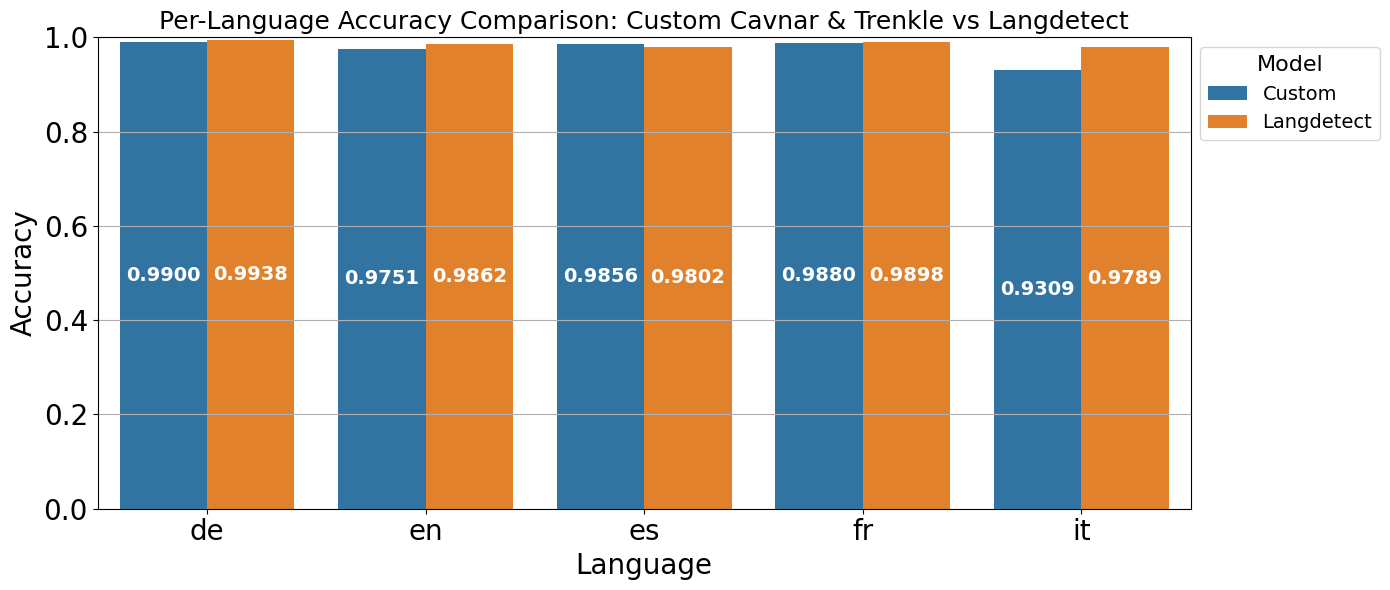

In [94]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

languages = sorted(list(set(results_custom["per_language"].keys()) |
                        set(results_langdetect["per_language"].keys())))

custom_accuracies = [results_custom["per_language"].get(lang, {"accuracy": 0})["accuracy"] for lang in languages]
langdetect_accuracies = [results_langdetect["per_language"].get(lang, {"accuracy": 0})["accuracy"] for lang in languages]

df = pd.DataFrame({
    "Language": languages,
    "Custom": custom_accuracies,
    "Langdetect": langdetect_accuracies
})

df_melted = df.melt(id_vars="Language", var_name="Model", value_name="Accuracy")

plt.figure(figsize=(14, 6))
ax = sns.barplot(data=df_melted, x="Language", y="Accuracy", hue="Model")

plt.ylim(0, 1)
plt.title("Per-Language Accuracy Comparison: Custom Cavnar & Trenkle vs Langdetect", fontsize=18)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.xlabel("Language", fontsize=20)
plt.grid(axis='y')

# Move legend outside
plt.legend(title="Model", fontsize=14, title_fontsize=16, loc='upper left', bbox_to_anchor=(1, 1))

# Annotate bars
for container in ax.containers:
    for bar in container:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height * 0.5,
            f"{height:.4f}",
            ha='center',
            va='center',
            fontsize=14,
            fontweight='bold',
            color='white'
        )

plt.tight_layout()
plt.show()


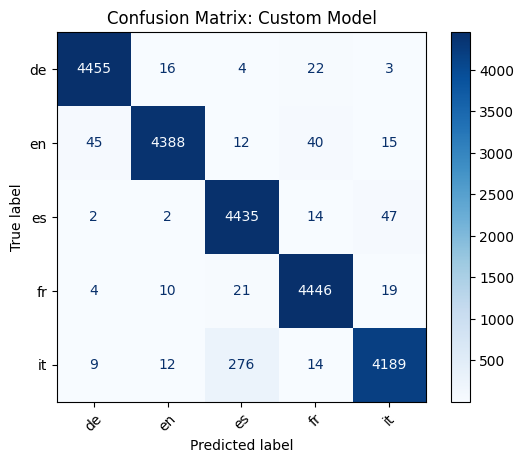

In [60]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_true = [sample["labels"] for sample in full_dataset]
y_pred = [language_identifier.identify_language(sample["text"])[0] for sample in full_dataset]

cm = confusion_matrix(y_true, y_pred, labels=languages)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=languages)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix: Custom Model")
plt.show()

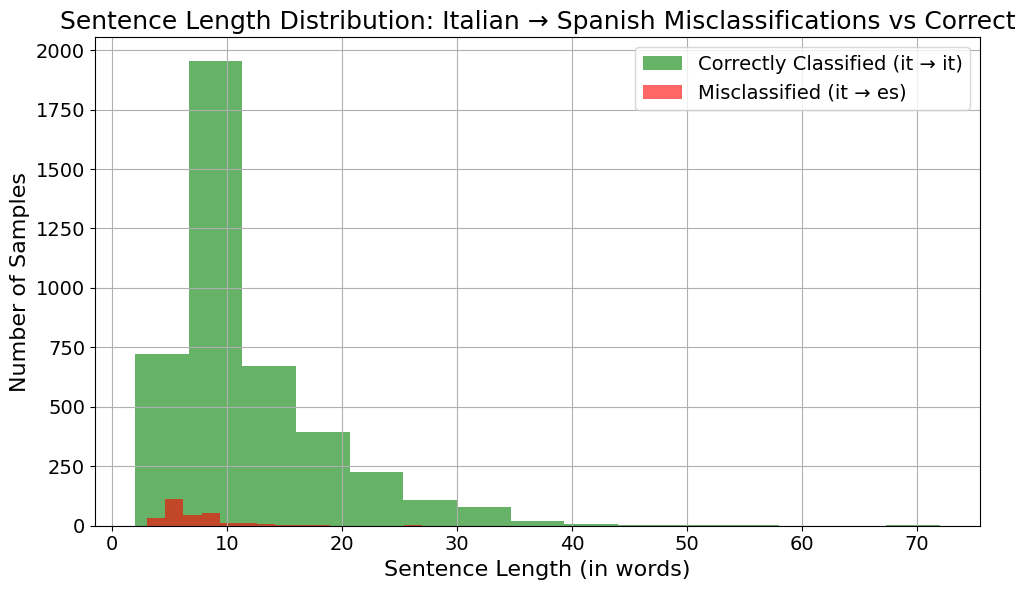


Average sentence length (Correctly classified): 11.77 words
Average sentence length (Misclassified as Spanish): 7.09 words


In [95]:
import matplotlib.pyplot as plt

misclassified_it_as_es = []
correctly_classified_it = []

for sample in full_dataset:
    if sample["labels"] == "it":
        predicted_label, _ = language_identifier.identify_language(sample["text"])
        if predicted_label == "es":
            misclassified_it_as_es.append(sample)
        elif predicted_label == "it":
            correctly_classified_it.append(sample)

misclassified_lengths = [len(sample["text"].split()) for sample in misclassified_it_as_es]
correct_lengths = [len(sample["text"].split()) for sample in correctly_classified_it]

plt.figure(figsize=(10, 6))
plt.hist(correct_lengths, bins=15, alpha=0.6, label="Correctly Classified (it → it)", color='green')
plt.hist(misclassified_lengths, bins=15, alpha=0.6, label="Misclassified (it → es)", color='red')

plt.xlabel("Sentence Length (in words)", fontsize=16)
plt.ylabel("Number of Samples", fontsize=16)
plt.title("Sentence Length Distribution: Italian → Spanish Misclassifications vs Correct", fontsize=18)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14, title_fontsize=15)
plt.grid(True)
plt.tight_layout()
plt.show()

avg_correct = sum(correct_lengths) / len(correct_lengths)
avg_misclassified = sum(misclassified_lengths) / len(misclassified_lengths)

print(f"\nAverage sentence length (Correctly classified): {avg_correct:.2f} words")
print(f"Average sentence length (Misclassified as Spanish): {avg_misclassified:.2f} words")


In [ ]:
def evaluate_custom_langdetect_2(dataset, model):
    total = 0
    correct = 0
    wrong = 0
    errors = 0
    language_counts = defaultdict(lambda: {"correct": 0, "total": 0})

    for sample in dataset:
        text = sample["text"]
        true_label = sample["labels"]

        try:
            predicted_label, _ = model.identify_language(text)
            if predicted_label == true_label:
                correct += 1
                language_counts[true_label]["correct"] += 1
            else:
                wrong += 1
            language_counts[true_label]["total"] += 1
            total += 1
        except Exception:
            errors += 1

    accuracy = correct / total if total > 0 else 0
    return {
        "overall_accuracy": accuracy,
        "per_language": {
            lang: {
                "accuracy": stats["correct"] / stats["total"],
                "correct": stats["correct"],
                "total": stats["total"]
            }
            for lang, stats in language_counts.items()
        }
    }


In [67]:
def train_and_evaluate_ngram_model(n, dataset, languages, training_text_dir):
    print(f"\n=== Evaluating for n={n} ===")
    model = LanguageIdentifier(n=n, top_k=400, penalty=400)

    for lang in languages:
        file_path = os.path.join(training_text_dir, f"{lang}.txt")
        with open(file_path, 'r', encoding='utf-8') as f:
            model.add_language(lang, f.read())

    return evaluate_custom_langdetect_2(dataset, model)

In [68]:
training_dir = os.path.join('..', 'languages')
languages = ['en', 'de', 'fr', 'it', 'es']

results_n3 = train_and_evaluate_ngram_model(3, full_dataset, languages, training_dir)
results_n4 = train_and_evaluate_ngram_model(4, full_dataset, languages, training_dir)
results_n5 = train_and_evaluate_ngram_model(5, full_dataset, languages, training_dir)



=== Evaluating for n=3 ===

=== Evaluating for n=4 ===

=== Evaluating for n=5 ===


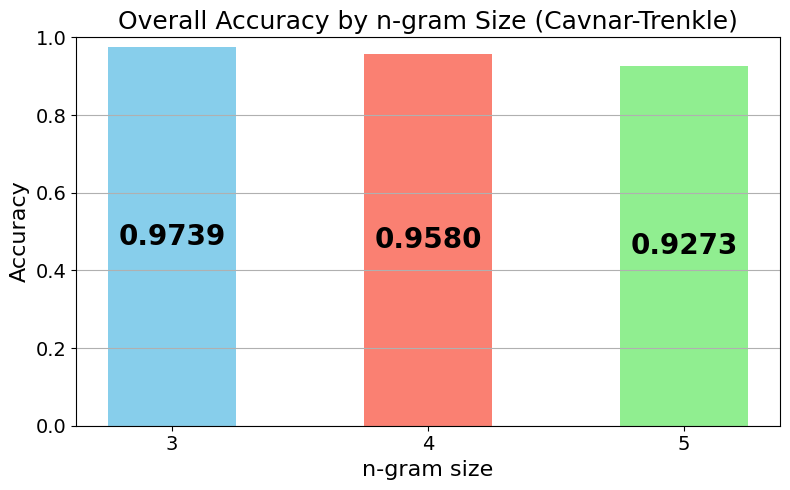

In [76]:
import matplotlib.pyplot as plt

ngram_sizes = [3, 4, 5]
accuracies = [
    results_n3["overall_accuracy"],
    results_n4["overall_accuracy"],
    results_n5["overall_accuracy"]
]

plt.figure(figsize=(8, 5))

bars = plt.bar(
    ngram_sizes,
    accuracies,
    width=0.5,
    color=["skyblue", "salmon", "lightgreen"]
)

plt.ylim(0, 1)
plt.xticks(ngram_sizes, fontsize=14)  # Tick labels
plt.yticks(fontsize=14)
plt.xlabel("n-gram size", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.title("Overall Accuracy by n-gram Size (Cavnar-Trenkle)", fontsize=18)
plt.grid(axis='y')

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height * 0.5,
        f"{height:.4f}",
        ha='center',
        va='center',
        color='black',
        fontsize=20,
        fontweight='bold'
    )

plt.tight_layout()
plt.show()

In [70]:
for n, res in zip(ngram_sizes, [results_n3, results_n4, results_n5]):
    print(f"\n--- Per-language accuracy for n={n} ---")
    for lang in languages:
        stats = res["per_language"].get(lang, {"accuracy": 0})
        print(f"{lang}: {stats['accuracy']:.4f}")



--- Per-language accuracy for n=3 ---
en: 0.9751
de: 0.9900
fr: 0.9880
it: 0.9309
es: 0.9856

--- Per-language accuracy for n=4 ---
en: 0.9580
de: 0.9818
fr: 0.9716
it: 0.9071
es: 0.9713

--- Per-language accuracy for n=5 ---
en: 0.9742
de: 0.9649
fr: 0.9378
it: 0.8251
es: 0.9344
